In [101]:
import os
import codecs
from urllib import unquote
import numpy as np
import pandas as pd
import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import pairwise_distances

###### Create list of files containing articles

In [98]:
# Path to folder where articles are stored.
# See the "Wikipedia Featured Articles dataset" Jupyter notebook for collection code.
path = 'D:\\Datasets\\Wikipedia Featured Articles 2'
# Get list of all article filenames.
filenames = [os.path.join(path, f) for f in os.listdir(path)]

In [3]:
len(filenames)

4627

In [4]:
# Get the contents of the article files.
file_contents = [[line[:-1] for line in codecs.open(fn, 'r', encoding='utf8').readlines()] for fn in filenames]

In [5]:
# Extract the article bodies.
articles = [tup[4] for tup in file_contents]

In [103]:
# Get just the article titles.
filenames = [unquote(n.split('\\')[-1]) for n in filenames]

In [7]:
# Build dicts of main and sub categories for each article.
main_category = {filenames[i]: file_contents[i][0] for i in xrange(len(filenames))}
sub_category = {filenames[i]: file_contents[i][1] for i in xrange(len(filenames))}

In [104]:
# Let's look at a some of the article names.
random.sample(filenames, 10)

['wiki_Abe_Waddington.txt',
 'wiki_This_Charming_Man.txt',
 'wiki_Richard_Nixon.txt',
 'wiki_Debora_Green.txt',
 'wiki_Flywheel,_Shyster,_and_Flywheel.txt',
 'wiki_Tomb_of_Antipope_John_XXIII.txt',
 'wiki_Aradia,_or_the_Gospel_of_the_Witches.txt',
 'wiki_Marcus_Ward_Lyon,_Jr..txt',
 'wiki_George_H._D._Gossip.txt',
 'wiki_Be_Here_Now_(album).txt']

###### Create CountVectorizer and pass it the list of filenames for reading and analyzing

In [100]:
# Create a CountVectorizer object from the articles. Tell it to use Int16 to save memory.
cv = CountVectorizer(dtype=np.int16)
count_mat = cv.fit_transform(articles)

In [9]:
count_mat

<4627x457811 sparse matrix of type '<type 'numpy.int64'>'
	with 8725085 stored elements in Compressed Sparse Row format>

In [10]:
# Create TfidfTransformer and transform the count matrix to a Tfidf weighted matrix.
tfidf = TfidfTransformer()
tfidf_mat = tfidf.fit_transform(count_mat)

In [11]:
# Calculate the distances between all pairs of documents using Euclidean distance.
dist_mat = pairwise_distances(tfidf_mat)

In [12]:
def get_closest_pairs(dist_mat, names, num=10, ignore_zeros=False):
    """Finds pairs with closest, optionally non-zero, distances."""
    dist_mat = np.copy(dist_mat)
    # Set zero values to infinity so they are ignore in the partitioning.
    dist_mat[np.triu_indices_from(dist_mat)] = np.inf
    if ignore_zeros:
        dist_mat[dist_mat == 0] = np.inf
    # Unravel the matrix indices and partition num lowest numbers.
    unr_index = np.unravel_index(dist_mat.argpartition(num, axis=None), dist_mat.shape)
    # Get document names for pairs.
    dist_pairs = [(names[unr_index[0][i]],        # First doc
                   names[unr_index[1][i]],        # Second doc
                   dist_mat[unr_index[0][i], unr_index[1][i]])   # Distance between docs
                   for i in xrange(num)]                # First num indices
    return sorted(dist_pairs, key=lambda tup: tup[2])

In [13]:
# Get the closest pairs of documents.
closest = get_closest_pairs(dist_mat, filenames)
closest

[('wiki_Leonard_Harrison_State_Park.txt',
  'wiki_Colton_Point_State_Park.txt',
  0.25721484181239529),
 ('wiki_Pedro_Afonso,_Prince_Imperial_of_Brazil.txt',
  'wiki_Afonso,_Prince_Imperial_of_Brazil.txt',
  0.27113690873245161),
 ('wiki_Quatermass_II.txt',
  'wiki_Bernard_Quatermass.txt',
  0.30051188293645192),
 ('wiki_Henrik_Sedin.txt', 'wiki_Daniel_Sedin.txt', 0.32461086701859732),
 ('wiki_The_Quatermass_Experiment.txt',
  'wiki_Quatermass_II.txt',
  0.32491596063792427),
 ('wiki_Halo_3.txt', 'wiki_Halo_2.txt', 0.32562154480132333),
 ('wiki_The_Quatermass_Experiment.txt',
  'wiki_Bernard_Quatermass.txt',
  0.32851367041911411),
 ('wiki_The_Heart_of_a_Woman.txt',
  "wiki_Themes_in_Maya_Angelou's_autobiographies.txt",
  0.33259657059955589),
 ('wiki_Premiership_of_John_Edward_Brownlee.txt',
  'wiki_John_Edward_Brownlee_as_Attorney-General_of_Alberta.txt',
  0.34222545276278082),
 ('wiki_History_of_Gillingham_F.C..txt',
  'wiki_Gillingham_F.C..txt',
  0.34327724832898077)]

In [14]:
def get_weighted_vocab(name, names, matrix, cv):
    """Get vocabulary with weights for document."""
    # Get the index of a song in the titles list.
    name_index = names.index(name)
    # This index corresponds the the row for this song in the matrix.
    # Get indices for all non-zero elements in the document vector.
    ind = np.nonzero(matrix[name_index])[1]
    # Create a term to index dict.
    t = zip(*cv.vocabulary_.items())
    term_ind = dict(zip(t[1], t[0]))
    return sorted([(matrix[name_index, i], term_ind[i]) for i in ind])

In [15]:
name = 'wiki_Leonard_Harrison_State_Park.txt'
get_weighted_vocab(name, filenames, tfidf_mat, cv)[-100:]

[(0.018993163015432718, u'fishers'),
 (0.019152353832306419, u'steven'),
 (0.019251318643134042, u'history'),
 (0.019292492562411945, u'pp'),
 (0.019389265699292904, u'map'),
 (0.019497099950987494, u'were'),
 (0.019876936625127038, u'1st'),
 (0.019913286736816908, u'with'),
 (0.020356447757010541, u'valley'),
 (0.020595664000367348, u'it'),
 (0.020602680327658215, u'iroquois'),
 (0.02069333701227662, u'45444'),
 (0.020733343163659674, u'shale'),
 (0.020917260504378293, u'commission'),
 (0.020999114808800557, u'miles'),
 (0.0212117605195607, u'at'),
 (0.021223639897788388, u'ed'),
 (0.021393449066528809, u'trout'),
 (0.021414142698472742, u'clearcutting'),
 (0.021432523541021656, u'69667'),
 (0.021435277727398543, u'camping'),
 (0.021854540393802101, u'along'),
 (0.022065825778261734, u'picnic'),
 (0.022815504592552271, u'bird'),
 (0.022901529727927517, u'land'),
 (0.023274197467782035, u'lycoming'),
 (0.023404860303783491, u'hardwoods'),
 (0.024112034406905857, u'nhs'),
 (0.0242982664

In [16]:
[get_weighted_vocab(fn, filenames, tfidf_mat, cv)[-1] for fn in filenames[50:60]]

[(0.44093671979112337, u'the'),
 (0.67429923993949148, u'di\u1ec7m'),
 (0.56651448638514756, u'di\u1ec7m'),
 (0.56288526656477045, u'the'),
 (0.42822823181554304, u'the'),
 (0.57386385583274546, u'thule'),
 (0.60911953486223003, u'whitlam'),
 (0.43256390052282506, u'the'),
 (0.4584685581814586, u'hunger'),
 (0.48992411774999634, u'the')]

<b>'the' shows up having the highest weight, but we know it is not useful for distinguishing documents.

<b>Certain words aren't useful for distinguishing between documents, so let's ignore them.<br>
scikit-learn has a handy list built in.

In [17]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [18]:
ENGLISH_STOP_WORDS

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [110]:
# Let's create the CountVectorizer again, but this time tell it to ignore certain words.
cv = CountVectorizer(stop_words='english', dtype=np.int16)
count_mat = cv.fit_transform(articles)

In [111]:
count_mat

<4627x457499 sparse matrix of type '<type 'numpy.int16'>'
	with 8003327 stored elements in Compressed Sparse Row format>

In [112]:
# Create a TfidfTransformer and transform the count matrix to a Tfidf weighted matrix.
tfidf = TfidfTransformer()
tfidf_mat = tfidf.fit_transform(count_mat)

In [113]:
# Calculate the distances between all pairs of documents using Euclidean distance.
dist_mat = pairwise_distances(tfidf_mat)

In [114]:
# Get the closest pairs of documents.
closest = get_closest_pairs(dist_mat, filenames)
closest

[('wiki_Quatermass_II.txt',
  'wiki_Bernard_Quatermass.txt',
  0.29761052196825583),
 ('wiki_Pedro_Afonso,_Prince_Imperial_of_Brazil.txt',
  'wiki_Afonso,_Prince_Imperial_of_Brazil.txt',
  0.30648409969507223),
 ('wiki_Leonard_Harrison_State_Park.txt',
  'wiki_Colton_Point_State_Park.txt',
  0.31048030186921821),
 ('wiki_The_Quatermass_Experiment.txt',
  'wiki_Bernard_Quatermass.txt',
  0.32442111758813724),
 ('wiki_Quatermass_and_the_Pit.txt',
  'wiki_Bernard_Quatermass.txt',
  0.34101594631559695),
 ('wiki_Henrik_Sedin.txt', 'wiki_Daniel_Sedin.txt', 0.341412107473759),
 ('wiki_Halo_3.txt', 'wiki_Halo_2.txt', 0.34276437689151867),
 ('wiki_The_Heart_of_a_Woman.txt',
  "wiki_Themes_in_Maya_Angelou's_autobiographies.txt",
  0.35134498930700803),
 ('wiki_The_Quatermass_Experiment.txt',
  'wiki_Quatermass_II.txt',
  0.35400851220054963),
 ('wiki_Shale_oil_extraction.txt', 'wiki_Oil_shale.txt', 0.3682527139035065)]

<b>We can see the order of the closest documents has changed some because stopwords are not being counted.

In [115]:
name = 'wiki_Leonard_Harrison_State_Park.txt'
get_weighted_vocab(name, filenames, tfidf_mat, cv)[-100:]

[(0.019547820932211874, u'hunting'),
 (0.020199545578900788, u'west'),
 (0.020333778708811985, u'cherry'),
 (0.020880274971736439, u'mile'),
 (0.020880274971736439, u'seasons'),
 (0.020979065146482921, u'laurel'),
 (0.020988315333150955, u'delaware'),
 (0.021112748365181018, u'rim'),
 (0.021692999593525934, u'hyner'),
 (0.021727811066337793, u'logs'),
 (0.02173389674363306, u'landmark'),
 (0.021890941143047769, u'potter'),
 (0.021964393551008585, u'clearcut'),
 (0.022211388367070352, u'deer'),
 (0.022443633169783185, u'wild'),
 (0.022520875659328286, u'campground'),
 (0.022590298071503184, u'shippen'),
 (0.022606600231333675, u'isbn'),
 (0.022667984892369764, u'000'),
 (0.023055799318550466, u'fishers'),
 (0.023249041040543476, u'steven'),
 (0.023369174417811181, u'history'),
 (0.023419155435678407, u'pp'),
 (0.023536628340088329, u'map'),
 (0.024128612044455402, u'1st'),
 (0.024710690575489646, u'valley'),
 (0.025009592276587601, u'iroquois'),
 (0.025119640420003666, u'45444'),
 (0.02

<b>Let's look at the distances between documents. What's a small distance? What's a large distance? It depends on the corpus.

<b>What's the smallest distance?

In [116]:
np.min(dist_mat[dist_mat>0])

0.29761052196825583

<br><b>We've already seen it and the pair of documents.

In [117]:
np.transpose((dist_mat==np.min(dist_mat[dist_mat>0])).nonzero())

array([[ 622, 3336],
       [3336,  622]], dtype=int64)

In [121]:
filenames[622]

'wiki_Bernard_Quatermass.txt'

In [122]:
filenames[3336]

'wiki_Quatermass_II.txt'

<br><b>What's the largest distance?

In [120]:
np.max(dist_mat)

1.4140692994157098

<br><b>Let's look at the distribution of distances to see where a good cut off for defining "close" documents might be.

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
# Get just the distances in the upper triangle.
dists = dist_mat[np.triu_indices_from(dist_mat, k=1)]

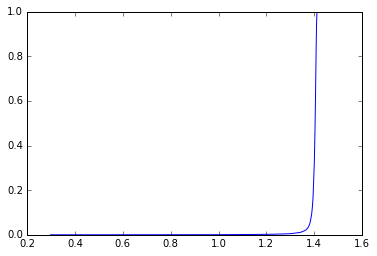

In [32]:
# Sort distances and plot as an empirical CDF.
sorted_dists = np.sort(dists)
plt.plot(sorted_dists, np.arange(len(sorted_dists))/float(len(sorted_dists)))
plt.show()

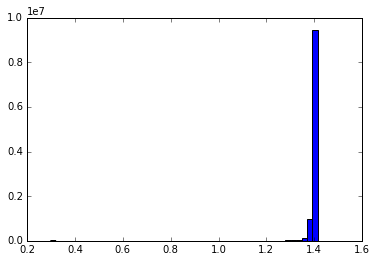

In [33]:
# Sometimes it is easier to see as a histogram.
plt.hist(sorted_dists, bins=50)
plt.show()

22,099 out of 10,702,251 distances between pairs of documents.
That's 0.21%


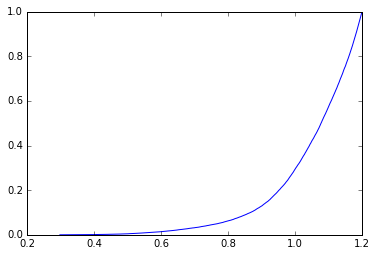

In [34]:
# It looks like the distances start to bulk up after 1.2, so let's look at everything less than that.
sorted_dists = np.sort(dists)
sorted_dists = sorted_dists[sorted_dists < 1.2]
plt.plot(sorted_dists, np.arange(len(sorted_dists))/float(len(sorted_dists)))
print('{:,} out of {:,} distances between pairs of documents.'.format(len(sorted_dists), len(dists)))
print('That\'s {:0.2%}'.format(len(sorted_dists)/float(len(dists))))
plt.show()

<b>So we might define a 'close' pair of documents as having a distance of less than 1.2.

<br><b>Now let's grab some documents and find their closest matches.

In [35]:
def get_closest_to(doc_name, doc_names, dist_mat):
    """Returns n closest documents to doc_name."""
    col = doc_names.index(doc_name)
    return sorted(zip([doc_name] * len(doc_names), doc_names, dist_mat[:, col]),
                  key=lambda tup: tup[2])

In [36]:
name = 'wiki_Leonard_Harrison_State_Park.txt'
name

'wiki_Leonard_Harrison_State_Park.txt'

In [37]:
close = pd.DataFrame(get_closest_to(name, filenames, dist_mat))
close

,0,1,2
0,wiki_Leonard_Harrison_State_Park.txt,wiki_Leonard_Harrison_State_Park.txt,0.000000
1,wiki_Leonard_Harrison_State_Park.txt,wiki_Colton_Point_State_Park.txt,0.310480
2,wiki_Leonard_Harrison_State_Park.txt,wiki_Upper_Pine_Bottom_State_Park.txt,0.611837
3,wiki_Leonard_Harrison_State_Park.txt,wiki_Worlds_End_State_Park.txt,0.903072
4,wiki_Leonard_Harrison_State_Park.txt,wiki_Cherry_Springs_State_Park.txt,0.996340
5,wiki_Leonard_Harrison_State_Park.txt,wiki_Black_Moshannon_State_Park.txt,1.072548
6,wiki_Leonard_Harrison_State_Park.txt,wiki_Ricketts_Glen_State_Park.txt,1.081710
7,wiki_Leonard_Harrison_State_Park.txt,wiki_Johnson_Creek_(Willamette_River).txt,1.123952
8,wiki_Leonard_Harrison_State_Park.txt,wiki_Quehanna_Wild_Area.txt,1.136567
9,wiki_Leonard_Harrison_State_Park.txt,wiki_White_Deer_Hole_Creek.txt,1.141047


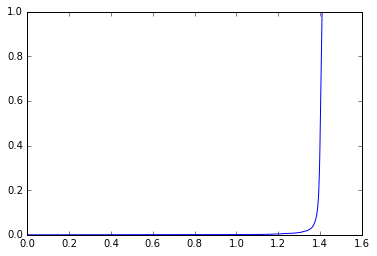

In [38]:
dists = close[2]
plt.plot(dists, np.arange(len(dists))/float(len(dists)))

Let's try a different article.

In [39]:
name = filenames[21]
name

'wiki_1689_Boston_revolt.txt'

In [40]:
close = pd.DataFrame(get_closest_to(name, filenames, dist_mat))
close

,0,1,2
0,wiki_1689_Boston_revolt.txt,wiki_1689_Boston_revolt.txt,0.000000
1,wiki_1689_Boston_revolt.txt,wiki_Boston.txt,1.230614
2,wiki_1689_Boston_revolt.txt,wiki_James_II_of_England.txt,1.291610
3,wiki_1689_Boston_revolt.txt,wiki_Plymouth_Colony.txt,1.297994
4,wiki_1689_Boston_revolt.txt,wiki_Samuel_Adams.txt,1.304380
5,wiki_1689_Boston_revolt.txt,wiki_USS_Massachusetts_(BB-2).txt,1.317292
6,wiki_1689_Boston_revolt.txt,wiki_British_Empire.txt,1.320046
7,wiki_1689_Boston_revolt.txt,wiki_Lieutenant_Governor_of_New_Jersey.txt,1.322996
8,wiki_1689_Boston_revolt.txt,wiki_Anne_Hutchinson.txt,1.326392
9,wiki_1689_Boston_revolt.txt,wiki_Charles_II_of_England.txt,1.327036


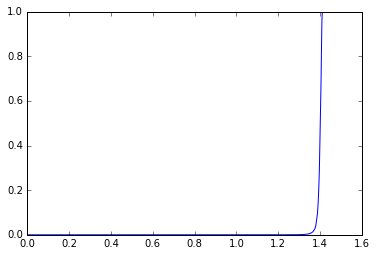

In [41]:
dists = close[2]
plt.plot(dists, np.arange(len(dists))/float(len(dists)))

In [42]:
name = 'wiki_X-Cops_(The_X-Files).txt'

In [43]:
close = pd.DataFrame(get_closest_to(name, filenames, dist_mat))
close

,0,1,2
0,wiki_X-Cops_(The_X-Files).txt,wiki_X-Cops_(The_X-Files).txt,0.000000
1,wiki_X-Cops_(The_X-Files).txt,wiki_The_Truth_(The_X-Files).txt,0.947266
2,wiki_X-Cops_(The_X-Files).txt,wiki_Triangle_(The_X-Files).txt,0.958782
3,wiki_X-Cops_(The_X-Files).txt,wiki_Deep_Throat_(The_X-Files_episode).txt,1.018039
4,wiki_X-Cops_(The_X-Files).txt,wiki_Ice_(The_X-Files).txt,1.022552
5,wiki_X-Cops_(The_X-Files).txt,wiki_Home_(The_X-Files).txt,1.030596
6,wiki_X-Cops_(The_X-Files).txt,wiki_All_things.txt,1.040942
7,wiki_X-Cops_(The_X-Files).txt,wiki_Deadalive.txt,1.081473
8,wiki_X-Cops_(The_X-Files).txt,wiki_Gender_Bender_(The_X-Files).txt,1.091989
9,wiki_X-Cops_(The_X-Files).txt,wiki_The_Post-Modern_Prometheus.txt,1.105198


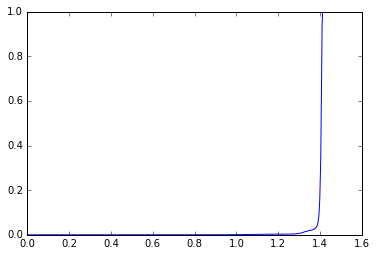

In [44]:
dists = close[2]
plt.plot(dists, np.arange(len(dists))/float(len(dists)))

<br>
### What about search?

What if we want to find an article related to some topic?

In [45]:
import sklearn

In [46]:
def search(new_doc, doc_names, count_vectorizer, tfidf_transformer, weight_docs_mat):
    """Search for the closest matches in the current texts to a new 
    document. This does not add the new document to the distance matrix.
    This uses the vocabulary created with the original documents, thus
    any new vocabulary words will be ignored.

    Parameters
    ----------
    new_doc : string
        Text of new documet to compare to existing documents.
    """
    # Create a new document vector from the new document.
    new_doc_count_vector = count_vectorizer.transform([new_doc])
    new_doc_vector = tfidf_transformer.transform(new_doc_count_vector)        

    # Compute the distances between the new documents and existing documents.
    dists = sklearn.metrics.pairwise.euclidean_distances(new_doc_vector, 
                                                         weight_docs_mat)        
    # Add labels, sort, and return.
    return sorted(zip(doc_names, dists[0]), key=lambda tup:tup[1])

In [47]:
query = 'baseball'
pd.DataFrame(search(query, filenames, cv, tfidf, tfidf_mat))

,0,1
0,wiki_Baseball.txt,0.710782
1,wiki_How_Brown_Saw_the_Baseball_Game.txt,0.948237
2,wiki_Doc_Adams.txt,1.167204
3,wiki_Lee_Smith_(baseball).txt,1.191062
4,wiki_Nashville_Sounds.txt,1.202303
5,wiki_Jackie_Robinson.txt,1.218215
6,wiki_Ozzie_Smith.txt,1.222822
7,wiki_2009_World_Series.txt,1.252505
8,wiki_Stan_Coveleski.txt,1.268970
9,wiki_Happy_Chandler.txt,1.271594


In [48]:
query = 'some other search'
pd.DataFrame(search(query, filenames, cv, tfidf, tfidf_mat))

,0,1
0,wiki_Astrophysics_Data_System.txt,1.295974
1,"wiki_World_Science_Festival,_2008.txt",1.380888
2,wiki_Halkett_boat.txt,1.381392
3,wiki_Planets_beyond_Neptune.txt,1.381807
4,wiki_Jeannette_Expedition.txt,1.383208
5,wiki_Australia_at_the_Winter_Olympics.txt,1.383840
6,wiki_Disappearance_of_Natalee_Holloway.txt,1.384049
7,wiki_Moors_murders.txt,1.386522
8,wiki_Charles_Eaton_(RAAF_officer).txt,1.387681
9,wiki_D._B._Cooper.txt,1.387825


In [49]:
query = 'x-files'
pd.DataFrame(search(query, filenames, cv, tfidf, tfidf_mat))

,0,1
0,wiki_Home_(The_X-Files).txt,1.113367
1,wiki_X-Cops_(The_X-Files).txt,1.141496
2,wiki_The_Truth_(The_X-Files).txt,1.145023
3,wiki_Ice_(The_X-Files).txt,1.145516
4,wiki_Terms_of_Endearment_(The_X-Files).txt,1.174454
5,wiki_Deep_Throat_(The_X-Files_episode).txt,1.182489
6,wiki_Triangle_(The_X-Files).txt,1.193986
7,wiki_The_Post-Modern_Prometheus.txt,1.207006
8,wiki_The_Unnatural_(The_X-Files).txt,1.217650
9,wiki_Squeeze_(The_X-Files).txt,1.222409


Let's see what weight 'x-files' has.

In [50]:
# First we need the index from the vocabulary, then look it up in tfidf's idf_ attribute.
cv.vocabulary_['x-files']

KeyError: 'x-files'

'x-files' is not in the vocabulary because the regex token_pattern splits on punctuation. To ensure that 'x-files' is used as a vocabulary word, we need to supply a custom token_pattern or a custom vocabulary list.

### Clustering

Now that we have a distance metric defined, we can do some clustering!

In [51]:
from sklearn.cluster import KMeans
from collections import Counter

In [52]:
# Create a KMeans object and give it the Tfidf matrix to cluster on rows.
km = KMeans(10)
km.fit(tfidf_mat)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [53]:
# Pair each article title with the cluster label.
labels_pairs = zip(km.labels_, filenames)
# Collect all articles by cluster.
clusters = {num: [tup[1] for tup in labels_pairs if tup[0] == num]
                    for num in set([t[0] for t in labels_pairs])}

###### Print out main category composition for each cluster

In [66]:
# For each article in each cluster, map the article to its main category.
cluster_main_categories = {}
for k,v in clusters.iteritems():
    cats = [main_category[article] for article in v]
    count = Counter(cats)
    cluster_main_categories[k] = count

In [67]:
for k,v in cluster_main_categories.iteritems():
    print('Cluster #' + str(k))
    print('Total articles in cluster: ' + str(sum(v.values())))
    print(pd.DataFrame(v.most_common(), columns=['Category', 'Count']))
    print('-'*50)

Cluster #0
Total articles in cluster: 155
                            Category  Count
0                            Warfare    148
1               Geography and places      2
2  Heraldry, honors, and vexillology      2
3            Politics and government      1
4                          Transport      1
5                            History      1
--------------------------------------------------
Cluster #1
Total articles in cluster: 232
  Category  Count
0    Music    232
--------------------------------------------------
Cluster #2
Total articles in cluster: 205
                             Category  Count
0                             Warfare    201
1                             History      2
2  Art, architecture, and archaeology      2
--------------------------------------------------
Cluster #3
Total articles in cluster: 79
               Category  Count
0  Sport and recreation     78
1               History      1
--------------------------------------------------
Cluster #4
T

###### Now let's do it for sub categories.

In [64]:
# For each article in each cluster, map the article to its main category.
cluster_sub_categories = {}
for k,v in clusters.iteritems():
    cats = [sub_category[article] for article in v]
    count = Counter(cats)
    cluster_sub_categories[k] = count

In [65]:
for k,v in cluster_sub_categories.iteritems():
    print('Cluster #' + str(k))
    print('Total articles in cluster: ' + str(sum(v.values())))
    print(pd.DataFrame(v.most_common(), columns=['Category', 'Count']))
    print('-'*50)

Cluster #0
Total articles in cluster: 155
                              Category  Count
0                  Warfare biographies     77
1             Wars, battles and events     38
2                                          27
3                     Warfare matériel     11
4  Politics and government biographies      1
5                Transport biographies      1
--------------------------------------------------
Cluster #1
Total articles in cluster: 232
            Category  Count
0                       160
1  Music biographies     72
--------------------------------------------------
Cluster #2
Total articles in cluster: 205
                   Category  Count
0          Warfare matériel    158
1  Wars, battles and events     37
2                                5
3       Warfare biographies      5
--------------------------------------------------
Cluster #3
Total articles in cluster: 79
                           Category  Count
0  Sport and recreation biographies     65
1            

###### Let's see them together.

In [68]:
# For each article in each cluster, map the article to its main category.
cluster_both_categories = {}
for k,v in clusters.iteritems():
    cats = [main_category[article] + ' : ' + sub_category[article] for article in v]
    count = Counter(cats)
    cluster_both_categories[k] = count

In [69]:
for k,v in cluster_both_categories.iteritems():
    print('Cluster #' + str(k))
    print('Total articles in cluster: ' + str(sum(v.values())))
    print('\n'.join([tup[0] + ' = ' + str(tup[1]) for tup in v.most_common()]))
    print('-'*50)

Cluster #0
Total articles in cluster: 155
Warfare : Warfare biographies = 77
Warfare : Wars, battles and events = 38
Warfare :  = 22
Warfare : Warfare matériel = 11
Geography and places :  = 2
Heraldry, honors, and vexillology :  = 2
History :  = 1
Politics and government : Politics and government biographies = 1
Transport : Transport biographies = 1
--------------------------------------------------
Cluster #1
Total articles in cluster: 232
Music :  = 160
Music : Music biographies = 72
--------------------------------------------------
Cluster #2
Total articles in cluster: 205
Warfare : Warfare matériel = 158
Warfare : Wars, battles and events = 37
Warfare : Warfare biographies = 5
History :  = 2
Art, architecture, and archaeology :  = 2
Warfare :  = 1
--------------------------------------------------
Cluster #3
Total articles in cluster: 79
Sport and recreation : Sport and recreation biographies = 65
Sport and recreation :  = 13
History :  = 1
---------------------------------------

Let's look at the most important words from each cluster.

In [60]:
# km.cluster_centers is a clusters X features array. Each row represents the weights of each feature for that's cluster's center.
# The features with the highest values are the most important terms in that cluster. 
# So let's get each row's sorted indices and reverse them, so each row in the return matrix an array of feature indices in
# descending order.
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

In [87]:
# Use the new array of sorted indices to print out the top terms for each cluster along with the most common main categories.
terms = cv.get_feature_names()
for i in range(10):
    print("Cluster %d:" % i)
    print('; '.join([tup[0] for tup in cluster_main_categories[i].most_common(3)]))
    for ind in order_centroids[i, :10]:
        print('    %s' % terms[ind])
    print('')

Cluster 0:
Warfare; Geography and places; Heraldry, honors, and vexillology
    australian
    raaf
    air
    squadron
    war
    australia
    force
    aircraft
    canberra
    japanese

Cluster 1:
Music
    album
    band
    music
    albums
    retrieved
    song
    chart
    songs
    billboard
    rock

Cluster 2:
Warfare; History; Art, architecture, and archaeology
    ship
    ships
    fleet
    battleships
    guns
    naval
    navy
    battleship
    japanese
    aircraft

Cluster 3:
Sport and recreation; History
    cricket
    innings
    test
    wickets
    australia
    bradman
    wisden
    match
    england
    runs

Cluster 4:
Geography and places; Warfare; Transport
    retrieved
    pp
    new
    edit
    10
    state
    highway
    2007
    isbn
    2008

Cluster 5:
Business, economics, and finance; Law; Art, architecture, and archaeology
    dollar
    mint
    coins
    coin
    cent
    eagle
    coinage
    silver
    liberty
    half

Cluster 6:
Med

Let's visit the documentation for the CountVectorizer and TfidfTransformer to look at some parameters.

Init signature: CountVectorizer(self, input=u'content', encoding=u'utf-8', decode_error=u'strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=u'(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), analyzer=u'word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<type 'numpy.int64'>)
Docstring:
Convert a collection of text documents to a matrix of token counts

This implementation produces a sparse representation of the counts using
scipy.sparse.coo_matrix.

If you do not provide an a-priori dictionary and you do not use an analyzer
that does some kind of feature selection then the number of features will
be equal to the vocabulary size found by analyzing the data.

Read more in the :ref:`User Guide <text_feature_extraction>`.

Parameters
----------
input : string {'filename', 'file', 'content'}
    If 'filename', the sequence passed as an argument to fit is
    expected to be a list of filenames that need reading to fetch
    the raw content to analyze.

    If 'file', the sequence items must have a 'read' method (file-like
    object) that is called to fetch the bytes in memory.

    Otherwise the input is expected to be the sequence strings or
    bytes items are expected to be analyzed directly.

encoding : string, 'utf-8' by default.
    If bytes or files are given to analyze, this encoding is used to
    decode.

decode_error : {'strict', 'ignore', 'replace'}
    Instruction on what to do if a byte sequence is given to analyze that
    contains characters not of the given `encoding`. By default, it is
    'strict', meaning that a UnicodeDecodeError will be raised. Other
    values are 'ignore' and 'replace'.

strip_accents : {'ascii', 'unicode', None}
    Remove accents during the preprocessing step.
    'ascii' is a fast method that only works on characters that have
    an direct ASCII mapping.
    'unicode' is a slightly slower method that works on any characters.
    None (default) does nothing.

analyzer : string, {'word', 'char', 'char_wb'} or callable
    Whether the feature should be made of word or character n-grams.
    Option 'char_wb' creates character n-grams only from text inside
    word boundaries.

    If a callable is passed it is used to extract the sequence of features
    out of the raw, unprocessed input.
    Only applies if ``analyzer == 'word'``.

preprocessor : callable or None (default)
    Override the preprocessing (string transformation) stage while
    preserving the tokenizing and n-grams generation steps.

tokenizer : callable or None (default)
    Override the string tokenization step while preserving the
    preprocessing and n-grams generation steps.
    Only applies if ``analyzer == 'word'``.

ngram_range : tuple (min_n, max_n)
    The lower and upper boundary of the range of n-values for different
    n-grams to be extracted. All values of n such that min_n <= n <= max_n
    will be used.

stop_words : string {'english'}, list, or None (default)
    If 'english', a built-in stop word list for English is used.

    If a list, that list is assumed to contain stop words, all of which
    will be removed from the resulting tokens.
    Only applies if ``analyzer == 'word'``.

    If None, no stop words will be used. max_df can be set to a value
    in the range [0.7, 1.0) to automatically detect and filter stop
    words based on intra corpus document frequency of terms.

lowercase : boolean, True by default
    Convert all characters to lowercase before tokenizing.

token_pattern : string
    Regular expression denoting what constitutes a "token", only used
    if ``analyzer == 'word'``. The default regexp select tokens of 2
    or more alphanumeric characters (punctuation is completely ignored
    and always treated as a token separator).

max_df : float in range [0.0, 1.0] or int, default=1.0
    When building the vocabulary ignore terms that have a document
    frequency strictly higher than the given threshold (corpus-specific
    stop words).
    If float, the parameter represents a proportion of documents, integer
    absolute counts.
    This parameter is ignored if vocabulary is not None.

min_df : float in range [0.0, 1.0] or int, default=1
    When building the vocabulary ignore terms that have a document
    frequency strictly lower than the given threshold. This value is also
    called cut-off in the literature.
    If float, the parameter represents a proportion of documents, integer
    absolute counts.
    This parameter is ignored if vocabulary is not None.

max_features : int or None, default=None
    If not None, build a vocabulary that only consider the top
    max_features ordered by term frequency across the corpus.

    This parameter is ignored if vocabulary is not None.

vocabulary : Mapping or iterable, optional
    Either a Mapping (e.g., a dict) where keys are terms and values are
    indices in the feature matrix, or an iterable over terms. If not
    given, a vocabulary is determined from the input documents. Indices
    in the mapping should not be repeated and should not have any gap
    between 0 and the largest index.

binary : boolean, default=False
    If True, all non zero counts are set to 1. This is useful for discrete
    probabilistic models that model binary events rather than integer
    counts.

dtype : type, optional
    Type of the matrix returned by fit_transform() or transform().

Attributes
----------
vocabulary_ : dict
    A mapping of terms to feature indices.

stop_words_ : set
    Terms that were ignored because they either:

      - occurred in too many documents (`max_df`)
      - occurred in too few documents (`min_df`)
      - were cut off by feature selection (`max_features`).

    This is only available if no vocabulary was given.

See also
--------
HashingVectorizer, TfidfVectorizer

Notes
-----
The ``stop_words_`` attribute can get large and increase the model size
when pickling. This attribute is provided only for introspection and can
be safely removed using delattr or set to None before pickling.
File:           c:\users\matt\anaconda\lib\site-packages\sklearn\feature_extraction\text.py
Type:           type

Init signature: TfidfTransformer(self, norm=u'l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
Docstring:
Transform a count matrix to a normalized tf or tf-idf representation

Tf means term-frequency while tf-idf means term-frequency times inverse
document-frequency. This is a common term weighting scheme in information
retrieval, that has also found good use in document classification.

The goal of using tf-idf instead of the raw frequencies of occurrence of a
token in a given document is to scale down the impact of tokens that occur
very frequently in a given corpus and that are hence empirically less
informative than features that occur in a small fraction of the training
corpus.

The actual formula used for tf-idf is tf * (idf + 1) = tf + tf * idf,
instead of tf * idf. The effect of this is that terms with zero idf, i.e.
that occur in all documents of a training set, will not be entirely
ignored. The formulas used to compute tf and idf depend on parameter
settings that correspond to the SMART notation used in IR, as follows:

Tf is "n" (natural) by default, "l" (logarithmic) when sublinear_tf=True.
Idf is "t" when use_idf is given, "n" (none) otherwise.
Normalization is "c" (cosine) when norm='l2', "n" (none) when norm=None.

Read more in the :ref:`User Guide <text_feature_extraction>`.

Parameters
----------
norm : 'l1', 'l2' or None, optional
    Norm used to normalize term vectors. None for no normalization.

use_idf : boolean, default=True
    Enable inverse-document-frequency reweighting.

smooth_idf : boolean, default=True
    Smooth idf weights by adding one to document frequencies, as if an
    extra document was seen containing every term in the collection
    exactly once. Prevents zero divisions.

sublinear_tf : boolean, default=False
    Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf).

References
----------

.. [Yates2011] `R. Baeza-Yates and B. Ribeiro-Neto (2011). Modern
               Information Retrieval. Addison Wesley, pp. 68-74.`

.. [MRS2008] `C.D. Manning, P. Raghavan and H. Schuetze  (2008).
               Introduction to Information Retrieval. Cambridge University
               Press, pp. 118-120.`
File:           c:\users\matt\anaconda\lib\site-packages\sklearn\feature_extraction\text.py
Type:           type